# Training length test for ARIMAX

In [100]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape
from sklearn.model_selection import TimeSeriesSplit
import pmdarima as pm
import matplotlib.pyplot as plt
from pmdarima.model_selection import SlidingWindowForecastCV, cross_validate

label = pd.read_pickle('label.pkl')
features = pd.read_pickle('2021_features.pkl')

In [101]:
def FeatureSelection(features, label, threshold):
    # 1.layer
    impute(features);
    features_filtered = select_features(features, label)
    # 2.layer
    model = linear_model.Lasso(alpha=0.1)
    # standardization
    X = StandardScaler().fit_transform(np.array(features_filtered))
    y = np.array(label)
    model.fit(X, y)
    feature_coeff = pd.Series(model.coef_, index=features_filtered.columns)
    feature_coeff = feature_coeff.sort_values(ascending=False)
    feature_names = feature_coeff[feature_coeff.abs()>threshold].index
    return feature_names

def ARIMACV(label, features, train_length, test_length, n_fold):
    # get label
    train_label = pd.Series(label[-train_length-test_length:-test_length].value)
    test_label = pd.Series(label[-test_length:].value)
    # get feature matrix
    train_features = features[-train_length-test_length:-test_length]
    test_features = features[-test_length:]
    # get train/test X
    relevant_feature_names = FeatureSelection(train_features, train_label, 0.3)
    train_X = StandardScaler().fit_transform(np.array(train_features[relevant_feature_names]))
    test_X = StandardScaler().fit_transform(np.array(test_features[relevant_feature_names]))
    # train ARIMAX
    model = auto_arima(train_label, max_p=8, max_q=8, max_order=None, \
        seasonal=False, m=24, \
        exogenous=train_X, \
        trace=False, error_action="ignore", suppress_warnings=True, stepwise=True)
    # evaluation
    train_pred = model.predict_in_sample(train_X)
    train_smap = round(100 - smape(train_label, train_pred),1)
    test_pred = model.predict(n_periods=test_label.shape[0], X=test_X)
    test_smap = round(100 - smape(test_label, test_pred),1)
    # cross validation
    val_cutoff = -(train_length+test_length)*n_fold
    if -val_cutoff <= len(features):
        val_label = pd.Series(label[val_cutoff:].value)
        val_features = features[val_cutoff:]
        step = train_length+test_length
    else:
        val_label = pd.Series(label[-len(features):].value)
        val_features = features
        step = round((len(features)-(train_length+test_length))/n_fold)
    # get validation data
    val_features = val_features[relevant_feature_names]
    val_X = StandardScaler().fit_transform(np.array(val_features))
    # cross validation
    cv = SlidingWindowForecastCV(window_size=train_length, step=step, h=test_length)
    cv_result = cross_validate(model, val_label, val_X, scoring='smape', cv=cv)
    print(f'--------------------------------------')
    print(f'train_smap: {train_smap}%')
    print(f'test_smap: {test_smap}%')
    print(f'cv_mean: {round(100-cv_result["test_score"].mean(),1)}%')
    print(f'cv_std: {cv_result["test_score"].std()}')
    return train_smap, test_smap, cv_result

In [102]:
train_lens = [
    [24,24*7,24*7*2,24*7*4,24*7*4*2,24*7*4*3,24*7*4*6],
    [24*7,24*7*2,24*7*4,24*7*4*2,24*7*4*3,24*7*4*6],
    [24*7,24*7*2,24*7*4,24*7*4*2,24*7*4*3,24*7*4*6]
]
test_lens = [1, 24, 24*7]
names = [
    ['1day', '1week', '2weeks', '1month', '2months', '3months', '6months'],
    ['1week', '2weeks', '1month', '2months', '3months', '6months'],
    ['1week', '2weeks', '1month', '2months', '3months', '6months']
]
test_names = ['1h', '1d', '1w']
n_fold = 5
result = dict()
for ind, test_name in enumerate(test_names):
    eval_result = dict()
    test_length = test_lens[ind]
    sub_train_lens = train_lens[ind]
    sub_names = names[ind]
    for index, train_length in enumerate(sub_train_lens):
        train_smap, test_smap, cv_result = ARIMACV(label, features, train_length, test_length, n_fold)
        eval_result[sub_names[index]] = (train_smap, test_smap, cv_result)
    result[test_name] = eval_result

--------------------------------------
train_smap: 98.8%
test_smap: 99.2%
cv_mean: 72.0%
cv_std: 11.232818218683619
--------------------------------------
train_smap: 90.7%
test_smap: 89.0%
cv_mean: 83.7%
cv_std: 12.432765629579844
--------------------------------------
train_smap: 92.7%
test_smap: 78.0%
cv_mean: 87.9%
cv_std: 7.9148548064560345
--------------------------------------
train_smap: 93.4%
test_smap: 72.0%
cv_mean: 91.3%
cv_std: 7.265376796488062
--------------------------------------
train_smap: 92.7%
test_smap: 73.2%
cv_mean: 90.7%
cv_std: 3.651860674024869
--------------------------------------
train_smap: 90.7%
test_smap: 82.3%
cv_mean: 76.8%
cv_std: 36.613271820987684
--------------------------------------
train_smap: 89.3%
test_smap: 99.2%
cv_mean: 95.4%
cv_std: 3.0017051425623653
--------------------------------------
train_smap: 89.2%
test_smap: 75.1%
cv_mean: nan%
cv_std: nan
--------------------------------------
train_smap: 90.9%
test_smap: 78.0%
cv_mean: nan%
cv

In [105]:
np.save('train_length.npy', result) # np.load('my_file.npy',allow_pickle='TRUE').item()

## Visualization

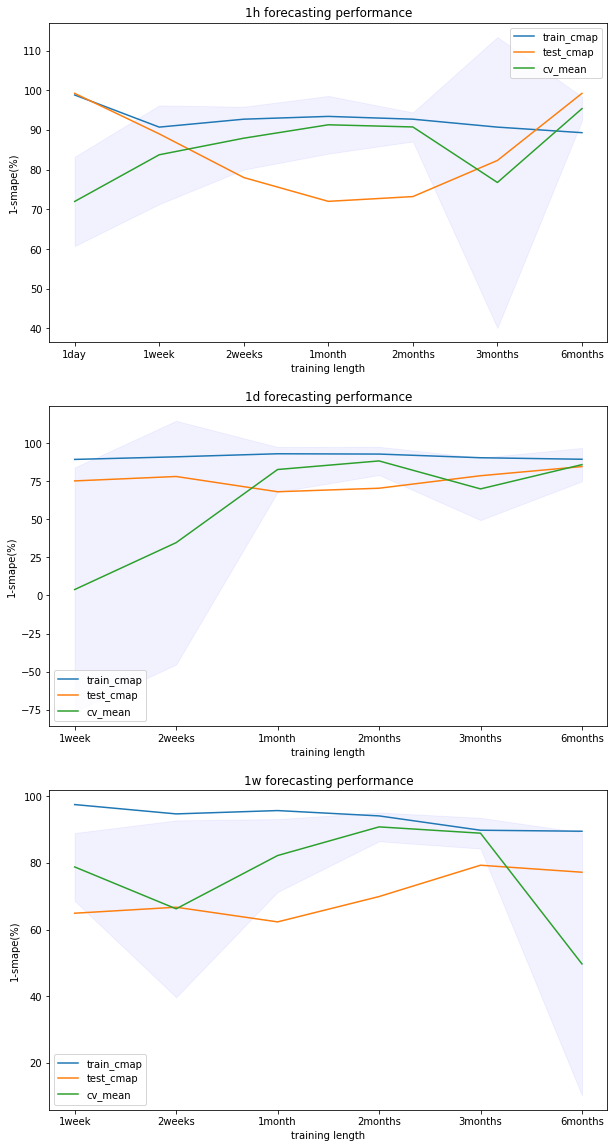

In [162]:
fig, ax = plt.subplots(3,1,figsize=(10,20))
for ind, test_name in enumerate(test_names):
    sub_names = names[ind]
    train_cmap = []
    test_cmap = []
    cv_mean = []
    low_bound = []
    up_bound = []
    for index, var_name in enumerate(sub_names):
        train_cmap.append(result[test_name][var_name][0])
        test_cmap.append(result[test_name][var_name][1])
        curr_cv_mean = 100-np.nanmean(result[test_name][var_name][2]['test_score'])
        cv_mean.append(curr_cv_mean)
        low_bound.append(curr_cv_mean-np.nanstd(result[test_name][var_name][2]['test_score']))
        up_bound.append(curr_cv_mean+np.nanstd(result[test_name][var_name][2]['test_score']))
    train_cmap = pd.DataFrame(train_cmap)
    test_cmap = pd.DataFrame(test_cmap)
    cv_mean = pd.DataFrame(cv_mean)
    low_bound = np.array(low_bound)
    up_bound = np.array(up_bound)
    # plot
    train_cmap.plot(ax=ax[ind])
    test_cmap.plot(ax=ax[ind])
    cv_mean.plot(ax=ax[ind])
    ax[ind].legend(['train_cmap','test_cmap','cv_mean'])
    ax[ind].set_xticklabels(['']+sub_names)
    ax[ind].set_ylabel('1-smape(%)')
    ax[ind].set_xlabel('training length')
    ax[ind].set_title(f'{test_name} forecasting performance')
    ax[ind].fill_between(np.arange(0,len(sub_names)), low_bound, up_bound, \
                  alpha=0.05, color='b')
